In [1]:
cd /notebooks/

/notebooks


In [2]:
from fastai import *
from fastai.text import *   # Quick accesss to NLP functionality

import torch.utils.data as data_utils
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import Sampler
from torch.autograd import Variable

import time
import importlib
import pixiedust
import spacy

Pixiedust database opened successfully


In [3]:
DATAPATH = Path('/data/WS/')
PATH = Path('/data/sav/WS/')

In [4]:
#DOWNLOAD THE DATA
!aws s3 cp --recursive s3://dbressbuck/data/WS /data/WS

download: s3://dbressbuck/data/WS/evaluate.csv to ../data/WS/evaluate.csv
download: s3://dbressbuck/data/WS/train.csv to ../data/WS/train.csv
download: s3://dbressbuck/data/WS/classifier_weights_001.pth to ../data/WS/classifier_weights_001.pth
download: s3://dbressbuck/data/WS/sent140_training.csv to ../data/WS/sent140_training.csv


# Preprocess the data

In [49]:
#load data, look at size of training sets and test set, look at some samples
df_trn = pd.read_csv(DATAPATH/'sent140_training.csv',encoding = "ISO-8859-1",names=['sentiment', 'id', 'date','flag','user','content'])
df_trn= df_trn[['sentiment','content']]
get_these=np.random.permutation(np.shape(df_trn)[0])
df_trn=df_trn.iloc[get_these[:750000]]#take a sample of 750K, due to time constraints

print(np.shape(df_trn))
print(df_trn.head())

(750000, 2)
         sentiment                                            content
477646           0  todays plans have been messed up as now not fe...
133647           0  Nose is completely stuffed and throat is sore ...
1196363          4                             Zero tolerence policy 
64522            0  How in the name of all that is holy did it get...
523066           0  @tlmasonaea I wish I could, but I live a bit t...


In [50]:
#there are some duplicate tweets... Take a quick look at them
print(np.shape(df_trn[~df_trn['content'].duplicated()]))
df_duplicated=df_trn[df_trn['content'].duplicated()]
df_duplicated.head()

(743815, 2)


,sentiment,content
132481,0,Headache
340713,0,isPlayer Has Died! Sorry
498708,0,I miss you
220156,0,I have a headache
650089,0,"Jogging, isnt REALLY that cool, especially if ..."


In [51]:
#remove duplicates... no reason to include these in training
df_trn=df_trn[~df_trn['content'].duplicated()]
print(np.shape(df_trn))

(743815, 2)


         sentiment                                            content  str_len
477646           0  todays plans have been messed up as now not fe...      101
133647           0  Nose is completely stuffed and throat is sore ...       85
1196363          4                             Zero tolerence policy        22
64522            0  How in the name of all that is holy did it get...       58
523066           0  @tlmasonaea I wish I could, but I live a bit t...       62


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3a484273c8>]], dtype=object)

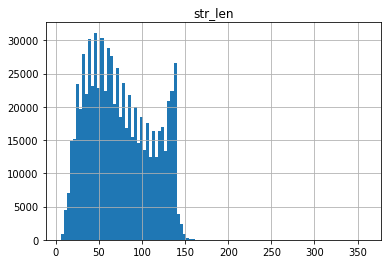

In [52]:
#create column to take a look at length of tweets, and create graph of distribution
df_trn['str_len']=df_trn['content'].str.len()
print(df_trn.head())
df_trn.hist(column='str_len', bins=100)

In [53]:
#Time permitting, investigate if there's anything peculiar 
    #about the spike at the right side of the graph above

[0 4]


(array([371759.,      0.,      0.,      0.,      0.,      0.,      0.,      0.,      0., 372056.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

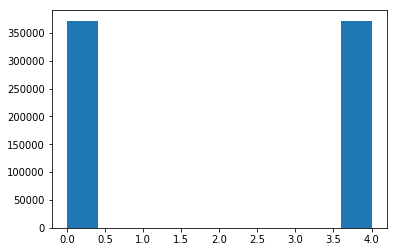

In [54]:
#look at distribution of labels... 
#2 categories, approximately equal number each
print(df_trn['sentiment'].unique()) #unique labels
plt.hist(list(df_trn['sentiment']))

# Build new training set for semi-supervised learning

### Goal: simulate common situation of: 1) Small labeled dataset, 2) Much larger unlabeled dataset

In [72]:
#grab 2% of the dataset as our labeled dataset
#the other 98% will serve as our 'unlabeled dataset'
    #but we'll still keep the labels
get_these=np.random.permutation(np.shape(df_trn)[0])
split_here=round(.02*np.shape(df_trn)[0])
df_labeled=df_trn.iloc[get_these[:split_here]]
df_unlabeled=df_trn.iloc[get_these[split_here:]]
print('labeled set size:', np.shape(df_labeled)[0])
print('unlabeled set size:',np.shape(df_unlabeled)[0])
assert np.shape(df_labeled)[0]+np.shape(df_unlabeled)[0]==np.shape(df_trn)[0], 'lengths dont add up'


labeled set size: 14876
unlabeled set size: 728939


In [73]:
#create train, valid, and test set from labeled data
get_these=np.random.permutation(np.shape(df_labeled)[0])
split_here1=round(.15*np.shape(df_labeled)[0])
split_here2=round(.3*np.shape(df_labeled)[0])
df_labeled_test=df_labeled.iloc[get_these[:split_here1]]
df_labeled_valid=df_labeled.iloc[get_these[split_here1:split_here2]]
df_labeled_trn=df_labeled.iloc[get_these[split_here2:]]
print('test set size:', np.shape(df_labeled_test)[0])
print('valid set size:', np.shape(df_labeled_valid)[0])
print('train set size:',np.shape(df_labeled_trn)[0])
assert np.shape(df_labeled_test)[0]+np.shape(df_labeled_valid)[0]+np.shape(df_labeled_trn)[0]==np.shape(df_labeled)[0], 'lengths dont add up'



df_labeled_valid['is_valid']=1
df_labeled_trn['is_valid']=0
df_unlabeled['is_valid']=0

#create a dataset made of df_labeled_trn and df_unlabeled
#this simulates situation where we have a much larger set of labeled data
df_large=pd.concat([df_labeled_trn,df_unlabeled])

print('larger set size:',np.shape(df_large)[0])



test set size: 2231
valid set size: 2232
train set size: 10413
larger set size: 739352


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

In [74]:
#For tri-training, we need 3 bootstrapped samples from the labeled train set
#That is, we need random sampling with replacement
sample_n=np.shape(df_labeled_trn)[0]

df_labeled_trn_s1=df_labeled_trn.sample(n=sample_n,replace=True)
df_labeled_trn_s2=df_labeled_trn.sample(n=sample_n,replace=True)
df_labeled_trn_s3=df_labeled_trn.sample(n=sample_n,replace=True)

#add in the validation set
df_labeled_trn_s1=pd.concat([df_labeled_trn_s1,df_labeled_valid])
df_labeled_trn_s2=pd.concat([df_labeled_trn_s2,df_labeled_valid])
df_labeled_trn_s3=pd.concat([df_labeled_trn_s3,df_labeled_valid])
df_large=pd.concat([df_large,df_labeled_valid])

print(df_labeled_trn_s1.head())
print(df_labeled_trn_s2.head())

print('size of each sample:',np.shape(df_labeled_trn_s1)[0])

assert np.shape(df_labeled_trn_s1)[0]==np.shape(df_labeled_trn_s2)[0]
assert np.shape(df_labeled_trn_s1)[0]==np.shape(df_labeled_trn_s3)[0]



         sentiment                                            content  \
877259           4  Talk about Different  I like this one  ? http:...   
1434762          4  Got a job at KFC, taking in some new hobbies, ...   
139399           0  @HeathCastor I dunno? I never been to a club. ...   
53857            0                                 My phone is dying    
976136           4                  is watching ellen degeneres show    

         str_len  is_valid  
877259        62         0  
1434762       84         0  
139399       116         0  
53857         18         0  
976136        33         0  
         sentiment                                            content  \
299472           0  Ditching school. Im gonna sleep. =P LOL. Watch...   
611166           0  @bear_smooter Even with a bottle of wine? That...   
777080           0  Running the M/V Donald Creppel *sigh* for the ...   
1414226          4  @myMisericordia oH I would love to see the dog...   
1109583          4  Wh

In [75]:
#Save all of our datasets!

df_trn.to_csv(DATAPATH/'df_full.csv', index=False)
df_large.to_csv(DATAPATH/'df_large.csv', index=False)

df_labeled.to_csv(DATAPATH/'df_labeled.csv', index=False)
df_unlabeled.to_csv(DATAPATH/'df_unlabeled.csv', index=False)

df_labeled_trn.to_csv(DATAPATH/'train_labeled.csv', index=False)
df_labeled_valid.to_csv(DATAPATH/'valid_labeled.csv', index=False)
df_labeled_test.to_csv(DATAPATH/'test_labeled.csv', index=False)

df_labeled_trn_s1.to_csv(DATAPATH/'train_labeled_s1.csv', index=False)
df_labeled_trn_s2.to_csv(DATAPATH/'train_labeled_s2.csv', index=False)
df_labeled_trn_s3.to_csv(DATAPATH/'train_labeled_s3.csv', index=False)




# Build and run language model on the full dataset

In [19]:
#set momentum values
moms = (0.8,0.7)

In [20]:
#language model data object
data_lm = TextLMDataBunch.from_csv(DATAPATH, 'df_full.csv')

In [21]:
#This is using fast.ai's pretrained language model:
#Model pretrained on wikitext103 dataset: 
    #https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/
    #~100M tokens, ~270K vocab
#Model based on Merity/Socher's AWD-LSTM quasi-recurrent neural network (QRNN)
    #https://arxiv.org/abs/1708.02182
learn = language_model_learner(data_lm, AWD_LSTM)
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-2), moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,4.500430,4.261662,0.252461,14:14
1,4.348021,4.134992,0.265569,14:16
2,4.225672,4.066481,0.272583,14:16
3,4.155884,4.047857,0.274637,14:16


In [22]:
#save weights from language model
learn.save_encoder('enc_LM_sent140')

# Build and run first round of classification models for tri-training

### This involves building and training three separate models, each based on one of the samples

In [563]:
#create datasets for classification models

#First some preprocessing for main training set:
df_test=pd.read_csv(DATAPATH/'valid_labeled.csv')
df_test['is_valid']=1
df_tmp = pd.read_csv(DATAPATH/'train_labeled.csv')
df_tmp['is_valid']=0
df_tmp=pd.concat([df_tmp,df_test])
df_tmp.to_csv(DATAPATH/'df_tmp.csv', index=False)
tmplist=TextList.from_csv(DATAPATH, 'df_tmp.csv', cols='content', vocab=data_lm.train_ds.vocab)
data_clas_main = (tmplist
                .split_from_df(col='is_valid')
                .label_from_df(cols='sentiment')#.add_test(test_list)
                .databunch(bs=40))



#Now for the samples...
text_train_list_s1=TextList.from_csv(DATAPATH, 'train_labeled_s1.csv', cols='content', vocab=data_lm.train_ds.vocab)
text_train_list_s2=TextList.from_csv(DATAPATH, 'train_labeled_s2.csv', cols='content', vocab=data_lm.train_ds.vocab)
text_train_list_s3=TextList.from_csv(DATAPATH, 'train_labeled_s3.csv', cols='content', vocab=data_lm.train_ds.vocab)
text_test_list=TextList.from_csv(DATAPATH, 'test_labeled.csv', cols='content', vocab=data_lm.train_ds.vocab)

text_large_list=TextList.from_csv(DATAPATH, 'df_large.csv', cols='content', vocab=data_lm.train_ds.vocab)

#The datasets for the 3 samples
data_clas_s1 = (text_train_list_s1
                .split_from_df(col='is_valid')
                .label_from_df(cols='sentiment')
                .add_test(text_test_list)
                .databunch(bs=40))

data_clas_s2 = (text_train_list_s2
                .split_from_df(col='is_valid')
                .label_from_df(cols='sentiment')
                .add_test(text_test_list)
                .databunch(bs=40))

data_clas_s3 = (text_train_list_s3
                .split_from_df(col='is_valid')
                .label_from_df(cols='sentiment')
                .add_test(text_test_list)
                .databunch(bs=40))

#Data for the much larger dataset
data_clas_large = (text_large_list
                .split_from_df(col='is_valid')
                .label_from_df(cols='sentiment')
                .add_test(text_test_list)
                .databunch(bs=40))


In [77]:
#Classification model based on Howard/Ruder's ULMFiT approach:
    #https://arxiv.org/abs/1801.06146
#Start with pretrained LM and fine-tune on dataset as above
#Keep the LM's "encoder" spine, but replace the head of the NN with a new network that predicts class
#This approach utilizes transfer learning to enhance the classifier's performance
#Also using one_cycle superconvergence: modify the learning rate and momentum value during training
    #Ramp up then down the LR, while ramping down then up the momentum
    #Significantly reduces training time and improves performance
    #From Leslie Smith's paper: https://arxiv.org/pdf/1803.09820.pdf

learn = text_classifier_learner(data_clas_s1, AWD_LSTM)
learn.load_encoder('enc_LM_sent140')#load in the weights from the LM encoder
learn.fit_one_cycle(4, moms=moms)


epoch,train_loss,valid_loss,accuracy,time
0,0.557100,0.473547,0.778674,00:10
1,0.538399,0.469144,0.786290,00:10
2,0.528870,0.458265,0.793011,00:10
3,0.522673,0.450327,0.797043,00:10


In [78]:
#Unfreeze all the layers and continue training:
#Above, all the layers except for the last layer is frozen
    #Idea is that "encoder" spine from the LM is fairly well-tuned, so only need to train the classifier head
#Once head has been trained, now we can train all the layers of the network
learn.unfreeze()
learn.fit_one_cycle(8, slice(1e-5,1e-3), moms=moms)
learn.save('s1_12e_unfreeze_001')



epoch,train_loss,valid_loss,accuracy,time
0,0.504981,0.447752,0.795251,00:20
1,0.502337,0.441159,0.802419,00:20
2,0.485947,0.434843,0.806452,00:20
3,0.464925,0.430869,0.800179,00:19
4,0.478139,0.427724,0.801971,00:20
5,0.441130,0.423802,0.807796,00:20
6,0.435809,0.424800,0.805556,00:19
7,0.436540,0.423292,0.805556,00:19


In [79]:
#Do same for s2
learn = text_classifier_learner(data_clas_s2, AWD_LSTM)
learn.load_encoder('enc_LM_sent140')#load in the weights from the LM encoder
learn.fit_one_cycle(4, moms=moms)
learn.unfreeze()
learn.fit_one_cycle(8, slice(1e-5,1e-3), moms=moms)
learn.save('s2_12e_unfreeze_001')

epoch,train_loss,valid_loss,accuracy,time
0,0.553158,0.479018,0.780018,00:10
1,0.529465,0.456275,0.788979,00:10
2,0.511834,0.449919,0.791219,00:10
3,0.511102,0.446709,0.795699,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.512473,0.443832,0.798835,00:20
1,0.496623,0.444081,0.794803,00:19
2,0.498999,0.439865,0.799731,00:20
3,0.480570,0.436788,0.801075,00:20
4,0.471058,0.432162,0.799283,00:20
5,0.449307,0.433056,0.804659,00:20
6,0.441979,0.432702,0.798387,00:20
7,0.438534,0.431688,0.799283,00:19


In [80]:
#Do same for s3
learn = text_classifier_learner(data_clas_s3, AWD_LSTM)
learn.load_encoder('enc_LM_sent140')#load in the weights from the LM encoder
learn.fit_one_cycle(4, moms=moms)
learn.unfreeze()
learn.fit_one_cycle(8, slice(1e-5,1e-3), moms=moms)
learn.save('s3_12e_unfreeze_001')

epoch,train_loss,valid_loss,accuracy,time
0,0.562157,0.463909,0.788082,00:10
1,0.537904,0.463287,0.791219,00:10
2,0.531749,0.453772,0.801075,00:10
3,0.515903,0.447557,0.801523,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.505817,0.446676,0.799283,00:20
1,0.511284,0.441550,0.801075,00:19
2,0.505528,0.438899,0.801523,00:20
3,0.484266,0.431523,0.801523,00:20
4,0.476524,0.427838,0.803315,00:19
5,0.461210,0.424891,0.811828,00:19
6,0.437228,0.423725,0.808692,00:20
7,0.437958,0.423919,0.814964,00:20


In [81]:
#Do same for large... 
#This simulates the situation where we have a much larger fully labeled dataset to work with
#Performance of this model is just being used as a benchmark...
    #it should be an upper bound for how well we can do with a semi-supervised approach
learn = text_classifier_learner(data_clas_large, AWD_LSTM)
learn.load_encoder('enc_LM_sent140')#load in the weights from the LM encoder
learn.fit_one_cycle(4, moms=moms)
learn.unfreeze()
learn.fit_one_cycle(8, slice(1e-5,1e-3), moms=moms)
learn.save('large_12e_unfreeze_001')

epoch,train_loss,valid_loss,accuracy,time
0,0.513515,0.425657,0.809588,07:28
1,0.514032,0.416941,0.812276,07:32
2,0.496843,0.411278,0.814516,07:17
3,0.498127,0.408943,0.819892,07:23


epoch,train_loss,valid_loss,accuracy,time
0,0.473285,0.385465,0.823477,19:16
1,0.442043,0.363186,0.838262,18:46
2,0.396280,0.347553,0.848118,18:39
3,0.401837,0.337543,0.859767,18:27
4,0.386306,0.332238,0.861559,19:18
5,0.388812,0.331113,0.861111,19:01
6,0.383931,0.326626,0.864695,19:06
7,0.398179,0.325612,0.866935,18:28


In [564]:
#Do same for main (unsampled) training set... 
learn = text_classifier_learner(data_clas_main, AWD_LSTM)
learn.load_encoder('enc_LM_sent140')#load in the weights from the LM encoder
learn.fit_one_cycle(4, moms=moms)
learn.unfreeze()
learn.fit_one_cycle(8, slice(1e-5,1e-3), moms=moms)
learn.save('main_12e_unfreeze_001')

epoch,train_loss,valid_loss,accuracy,time
0,0.561704,0.481441,0.781362,00:12
1,0.549204,0.465433,0.793907,00:12
2,0.536986,0.450241,0.802419,00:12
3,0.525893,0.447468,0.800179,00:12


epoch,train_loss,valid_loss,accuracy,time
0,0.526163,0.442150,0.805108,00:22
1,0.520787,0.434077,0.810932,00:21
2,0.512583,0.430157,0.809140,00:22
3,0.480988,0.423372,0.808692,00:22
4,0.489114,0.422890,0.805556,00:21
5,0.468415,0.418971,0.811380,00:22
6,0.475307,0.417309,0.813172,00:21
7,0.480229,0.418968,0.811380,00:22


### Get predictions on unlabeled data from all three samples

In [920]:
#Construct a data structure for making predictions on the unlabeled data
df_test=pd.read_csv(DATAPATH/'df_unlabeled.csv')
df_test['is_valid']=1

df_tmp = pd.read_csv(DATAPATH/'train_labeled_s1.csv')
df_tmp=df_tmp[df_tmp['is_valid']==0]
df_tmp=pd.concat([df_tmp,df_test])

df_tmp.to_csv(DATAPATH/'df_tmp.csv', index=False)
tmplist=TextList.from_csv(DATAPATH, 'df_tmp.csv', cols='content', vocab=data_lm.train_ds.vocab)
data_tmp = (tmplist
                .split_from_df(col='is_valid')
                .label_from_df(cols='sentiment')
                .databunch(bs=40))



In [921]:
#make predictions on the unlabeled data, for all three samples
learn = text_classifier_learner(data_tmp, AWD_LSTM)
learn.load('s1_12e_unfreeze_001')
predictions_s1=learn.get_preds(DatasetType.Valid,ordered=True)
learn.load('s2_12e_unfreeze_001')
predictions_s2=learn.get_preds(DatasetType.Valid,ordered=True)
learn.load('s3_12e_unfreeze_001')
predictions_s3=learn.get_preds(DatasetType.Valid,ordered=True)

In [922]:
#convert prediction probabilities into np arrays, and concatenate
predictions_probs=np.stack([predictions_s1[0].cpu().numpy()[:,0],
                            predictions_s2[0].cpu().numpy()[:,0],
                            predictions_s3[0].cpu().numpy()[:,0]],1)


In [923]:
#Do various pre-processing useful for deciding which unlabeled examples
    # go to which samples

#predictions for each of 3 samples
predictions_predtargets=(predictions_probs>.5).astype(int)
#average prediction
ave_pred=np.mean(predictions_predtargets,axis=1)
#get average probability over 3 samples:
ave_prob=np.mean(predictions_probs,axis=1)
#get standard deviation over 3 samples:
std_prob=np.std(predictions_probs,axis=1)
#get biggest differences bw ave of 2 and the third
dif_prob_12m3=np.mean(predictions_probs[:,[0,1]],axis=1)-predictions_probs[:,2]
dif_prob_13m2=np.mean(predictions_probs[:,[0,2]],axis=1)-predictions_probs[:,1]
dif_prob_23m1=np.mean(predictions_probs[:,[1,2]],axis=1)-predictions_probs[:,0]
#get individual samples probs
s1_prediction_probs=predictions_probs[:,0]
s2_prediction_probs=predictions_probs[:,1]
s3_prediction_probs=predictions_probs[:,2]
#get averages between pairings of 2 samples
ave_prob12=np.mean(predictions_probs[:,[0,1]],axis=1)
ave_prob13=np.mean(predictions_probs[:,[0,2]],axis=1)
ave_prob23=np.mean(predictions_probs[:,[1,2]],axis=1)
#set target to 1 or 0 based on ave_pred:
ave_prob_target=np.round(ave_pred).astype('int')
#get the indices of the max and min values
probs_max_ind=np.argmax(predictions_probs,axis=1)
probs_min_ind=np.argmin(predictions_probs,axis=1)


standard deviation between three models prediction labels:  0.044066004


(array([1.00000e+00, 2.00000e+00, 6.00000e+00, 5.00000e+00, 1.50000e+01, 2.70000e+01, 4.40000e+01, 6.80000e+01,
        1.37000e+02, 2.30000e+02, 3.62000e+02, 5.66000e+02, 9.83000e+02, 1.51200e+03, 2.42700e+03, 3.83300e+03,
        5.95000e+03, 9.25600e+03, 1.38740e+04, 2.14060e+04, 3.23460e+04, 5.03180e+04, 8.75960e+04, 1.68758e+05,
        8.81120e+04, 6.10790e+04, 4.59570e+04, 3.57090e+04, 2.72180e+04, 2.08260e+04, 1.52500e+04, 1.12110e+04,
        7.87000e+03, 5.46100e+03, 3.83300e+03, 2.48500e+03, 1.57200e+03, 1.05500e+03, 6.52000e+02, 3.60000e+02,
        2.19000e+02, 1.76000e+02, 7.20000e+01, 4.40000e+01, 1.90000e+01, 1.30000e+01, 1.20000e+01, 7.00000e+00,
        3.00000e+00, 2.00000e+00]),
 array([-0.559595, -0.53567 , -0.511745, -0.48782 , ...,  0.564884,  0.58881 ,  0.612735,  0.63666 ], dtype=float32),
 <a list of 50 Patch objects>)

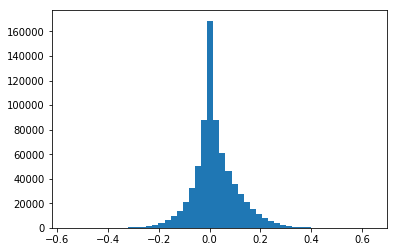

In [924]:
# the difference in predicted label between
    #a single sample and the average of the other two samples
#The vast majority of generated predictions are very similar between the three models 
print('standard deviation between three models prediction labels: ',np.mean(np.std(predictions_probs,axis=1)))
plt.hist(dif_prob_12m3,50)


(array([18668., 19357., 15489., 13325., ..., 13230., 14515., 16023., 14599.]),
 array([1.470389e-04, 1.014541e-02, 2.014377e-02, 3.014214e-02, ..., 9.699886e-01, 9.799870e-01, 9.899853e-01,
        9.999837e-01], dtype=float32),
 <a list of 100 Patch objects>)

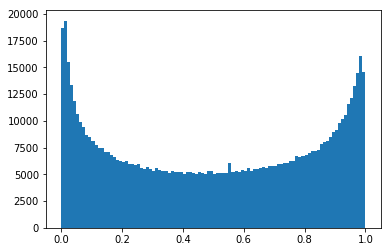

In [925]:
#The distribution of the generated probabilities
#The distribution has peaks at 0 and 1, since it is trained to discriminate Neg from Pos
plt.hist(ave_prob,100)

### Continue tri-training with the unlabeled dataset's predicted labels

In [926]:
get_top_n=5000# Get top 10K examples (5K of '0' and 5K of '1') of most certain pair-predicted labels 
df_test=pd.read_csv(DATAPATH/'df_unlabeled.csv')
df_test['ave_prob12']=ave_prob12
df_test['ave_prob13']=ave_prob13
df_test['ave_prob23']=ave_prob23
df_test['dif_prob_23m1']=dif_prob_23m1
df_test['dif_prob_13m2']=dif_prob_13m2
df_test['dif_prob_12m3']=dif_prob_12m3
df_test['s1_prediction_probs']=s1_prediction_probs
df_test['s2_prediction_probs']=s2_prediction_probs
df_test['s3_prediction_probs']=s3_prediction_probs
print(np.shape(df_test))

df_tmp = pd.read_csv(DATAPATH/'train_labeled_s1.csv')
df_tmp.to_csv(DATAPATH/'train_labeled_s1_tmp.csv', index=False)
df_tmp = pd.read_csv(DATAPATH/'train_labeled_s2.csv')
df_tmp.to_csv(DATAPATH/'train_labeled_s2_tmp.csv', index=False)
df_tmp = pd.read_csv(DATAPATH/'train_labeled_s3.csv')
df_tmp.to_csv(DATAPATH/'train_labeled_s3_tmp.csv', index=False)


(728939, 13)


In [927]:
#for s1
ave_prob_pair=np.array(df_test['ave_prob23'])
dif_prob_pair_m_s=np.array(df_test['dif_prob_23m1'])
s_prediction_probs=np.array(df_test['s1_prediction_probs'])
csv_name='train_labeled_s1_tmp.csv'
df_tmp = pd.read_csv(DATAPATH/csv_name)
#set targets to the mean of pair
ave_prob_target_tmp=np.round(ave_prob_pair).astype(int)
ave_prob_target_tmp[ave_prob_target_tmp==0]=4
ave_prob_target_tmp[ave_prob_target_tmp==1]=0
print(np.shape(ave_prob_target_tmp))
#get thresholds
ave_prob_pair_sorted=np.sort(ave_prob_pair)
low_thresh=ave_prob_pair_sorted[get_top_n]
high_thresh=ave_prob_pair_sorted[len(ave_prob_pair_sorted)-get_top_n]
get_these=np.zeros(np.shape(ave_prob_pair)[0])
get_these[ave_prob_pair<low_thresh]=1
get_these[ave_prob_pair>high_thresh]=1
get_these=get_these.astype(bool)
print(np.shape(ave_prob_target_tmp[get_these]))
#get selections
ave_prob_pair_tmp=ave_prob_pair[get_these]
s_prediction_probs_tmp=s_prediction_probs[get_these]
dif_prob_pair_m_s_tmp=dif_prob_pair_m_s[get_these]
ave_prob_target_tmp=ave_prob_target_tmp[get_these]
print(np.shape(ave_prob_pair_tmp))
#modify df_test_tmp
df_test_tmp=df_test.iloc[get_these]
print(np.shape(df_test_tmp))
df_test=df_test[~get_these]
print(np.shape(df_test))
df_test_tmp['sentiment']=ave_prob_target_tmp
#df_test_tmp['sentiment'].iloc[get_these_s1]=s_prediction_preds[get_these_s1]
df_test_tmp['is_valid']=0
#create expanded data for further training of sample's model
df_tmp=pd.concat([df_tmp,df_test_tmp])
df_tmp.to_csv(DATAPATH/csv_name, index=False)
tmplist=TextList.from_csv(DATAPATH, csv_name, cols='content', vocab=data_lm.train_ds.vocab)
data_tmp = (tmplist
                .split_from_df(col='is_valid')
                .label_from_df(cols='sentiment')
                .databunch(bs=40))


In [928]:
#Continue training model using the pseudo-labels
print(np.shape(df_tmp))
print(np.shape(df_test))
learn = text_classifier_learner(data_tmp, AWD_LSTM)
learn.load('s1_12e_unfreeze_001')#load in the weights from the LM encoder
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-5,1e-3), moms=moms)
learn.save('s1_16e_tritrained_001')

(22644, 13)
(718940, 13)


epoch,train_loss,valid_loss,accuracy,time
0,0.272075,0.426291,0.805556,00:37
1,0.246473,0.429492,0.802867,00:38
2,0.253791,0.427987,0.806900,00:38
3,0.242967,0.428436,0.810036,00:38


In [929]:
#for s2
ave_prob_pair=np.array(df_test['ave_prob13'])
dif_prob_pair_m_s=np.array(df_test['dif_prob_13m2'])
s_prediction_probs=np.array(df_test['s2_prediction_probs'])
csv_name='train_labeled_s2_tmp.csv'
df_tmp = pd.read_csv(DATAPATH/csv_name)
#set targets to the mean of pair
ave_prob_target_tmp=np.round(ave_prob_pair).astype(int)
ave_prob_target_tmp[ave_prob_target_tmp==0]=4
ave_prob_target_tmp[ave_prob_target_tmp==1]=0
print(np.shape(ave_prob_target_tmp))
#get thresholds
ave_prob_pair_sorted=np.sort(ave_prob_pair)
low_thresh=ave_prob_pair_sorted[get_top_n]
high_thresh=ave_prob_pair_sorted[len(ave_prob_pair_sorted)-get_top_n]
get_these=np.zeros(np.shape(ave_prob_pair)[0])
get_these[ave_prob_pair<low_thresh]=1
get_these[ave_prob_pair>high_thresh]=1
get_these=get_these.astype(bool)
print(np.shape(ave_prob_target_tmp[get_these]))
#get selections
ave_prob_pair_tmp=ave_prob_pair[get_these]
s_prediction_probs_tmp=s_prediction_probs[get_these]
dif_prob_pair_m_s_tmp=dif_prob_pair_m_s[get_these]
ave_prob_target_tmp=ave_prob_target_tmp[get_these]
print(np.shape(ave_prob_pair_tmp))
#modify df_test_tmp
df_test_tmp=df_test.iloc[get_these]
print(np.shape(df_test_tmp))
df_test=df_test[~get_these]
print(np.shape(df_test))
df_test_tmp['sentiment']=ave_prob_target_tmp
#df_test_tmp['sentiment'].iloc[get_these_s1]=s_prediction_preds[get_these_s1]
df_test_tmp['is_valid']=0
#create expanded data for further training of sample's model
df_tmp=pd.concat([df_tmp,df_test_tmp])
df_tmp.to_csv(DATAPATH/csv_name, index=False)
tmplist=TextList.from_csv(DATAPATH, csv_name, cols='content', vocab=data_lm.train_ds.vocab)
data_tmp = (tmplist
                .split_from_df(col='is_valid')
                .label_from_df(cols='sentiment')
                .databunch(bs=40))


In [930]:
#Continue training model using the pseudo-labels
print(np.shape(df_tmp))
print(np.shape(df_test))
learn = text_classifier_learner(data_tmp, AWD_LSTM)
learn.load('s2_12e_unfreeze_001')#load in the weights from the LM encoder
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-5,1e-3), moms=moms)
learn.save('s2_16e_tritrained_001')

(22644, 13)
(708941, 13)


epoch,train_loss,valid_loss,accuracy,time
0,0.268938,0.440734,0.797043,00:38
1,0.256114,0.439992,0.798835,00:38
2,0.245596,0.438050,0.798387,00:37
3,0.251346,0.438122,0.801971,00:39


In [931]:
#for s3
ave_prob_pair=np.array(df_test['ave_prob12'])
dif_prob_pair_m_s=np.array(df_test['dif_prob_12m3'])
s_prediction_probs=np.array(df_test['s3_prediction_probs'])
csv_name='train_labeled_s3_tmp.csv'
df_tmp = pd.read_csv(DATAPATH/csv_name)
#set targets to the mean of pair
ave_prob_target_tmp=np.round(ave_prob_pair).astype(int)
ave_prob_target_tmp[ave_prob_target_tmp==0]=4
ave_prob_target_tmp[ave_prob_target_tmp==1]=0
print(np.shape(ave_prob_target_tmp))
#get thresholds
ave_prob_pair_sorted=np.sort(ave_prob_pair)
low_thresh=ave_prob_pair_sorted[get_top_n]
high_thresh=ave_prob_pair_sorted[len(ave_prob_pair_sorted)-get_top_n]
get_these=np.zeros(np.shape(ave_prob_pair)[0])
get_these[ave_prob_pair<low_thresh]=1
get_these[ave_prob_pair>high_thresh]=1
get_these=get_these.astype(bool)
print(np.shape(ave_prob_target_tmp[get_these]))
#get selections
ave_prob_pair_tmp=ave_prob_pair[get_these]
s_prediction_probs_tmp=s_prediction_probs[get_these]
dif_prob_pair_m_s_tmp=dif_prob_pair_m_s[get_these]
ave_prob_target_tmp=ave_prob_target_tmp[get_these]
print(np.shape(ave_prob_pair_tmp))
#modify df_test_tmp
df_test_tmp=df_test.iloc[get_these]
print(np.shape(df_test_tmp))
df_test=df_test[~get_these]
print(np.shape(df_test))
df_test_tmp['sentiment']=ave_prob_target_tmp
#df_test_tmp['sentiment'].iloc[get_these_s1]=s_prediction_preds[get_these_s1]
df_test_tmp['is_valid']=0
#create expanded data for further training of sample's model
df_tmp=pd.concat([df_tmp,df_test_tmp])
df_tmp.to_csv(DATAPATH/csv_name, index=False)
tmplist=TextList.from_csv(DATAPATH, csv_name, cols='content', vocab=data_lm.train_ds.vocab)
data_tmp = (tmplist
                .split_from_df(col='is_valid')
                .label_from_df(cols='sentiment')
                .databunch(bs=40))


In [932]:
#Continue training model using the pseudo-labels
print(np.shape(df_tmp))
print(np.shape(df_test))
learn = text_classifier_learner(data_tmp, AWD_LSTM)
learn.load('s3_12e_unfreeze_001')#load in the weights from the LM encoder
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-5,1e-3), moms=moms)
learn.save('s3_16e_tritrained_001')

(22644, 13)
(698942, 13)


epoch,train_loss,valid_loss,accuracy,time
0,0.265480,0.425043,0.813620,00:38
1,0.253222,0.415999,0.803763,00:38
2,0.245343,0.423436,0.814068,00:38
3,0.237727,0.423912,0.810484,00:38


### Round 2 of predictions and tri-training

In [933]:
#Construct a data structure for making predictions on the unlabeled data
df_test['is_valid']=1

df_tmp = pd.read_csv(DATAPATH/'train_labeled_s1.csv')
df_tmp=df_tmp[df_tmp['is_valid']==0]
df_tmp=pd.concat([df_tmp,df_test])

df_tmp.to_csv(DATAPATH/'df_tmp.csv', index=False)
tmplist=TextList.from_csv(DATAPATH, 'df_tmp.csv', cols='content', vocab=data_lm.train_ds.vocab)
data_tmp = (tmplist
                .split_from_df(col='is_valid')
                .label_from_df(cols='sentiment')
                .databunch(bs=40))

#make predictions on the unlabeled data, for all three samples
learn = text_classifier_learner(data_tmp, AWD_LSTM)
learn.load('s1_16e_tritrained_001')
predictions_s1_2=learn.get_preds(DatasetType.Valid,ordered=True)
learn.load('s2_16e_tritrained_001')
predictions_s2_2=learn.get_preds(DatasetType.Valid,ordered=True)
learn.load('s3_16e_tritrained_001')
predictions_s3_2=learn.get_preds(DatasetType.Valid,ordered=True)

#convert prediction probabilities into np arrays, and concatenate
predictions_probs=np.stack([predictions_s1_2[0].cpu().numpy()[:,0],
                            predictions_s2_2[0].cpu().numpy()[:,0],
                            predictions_s3_2[0].cpu().numpy()[:,0]],1)

In [934]:
#df_test=pd.read_csv(DATAPATH/'df_unlabeled.csv')

#get averages between pairings of 2 samples
ave_prob12=np.mean(predictions_probs[:,[0,1]],axis=1)
ave_prob13=np.mean(predictions_probs[:,[0,2]],axis=1)
ave_prob23=np.mean(predictions_probs[:,[1,2]],axis=1)

df_test['ave_prob12']=ave_prob12
df_test['ave_prob13']=ave_prob13
df_test['ave_prob23']=ave_prob23
print(np.shape(df_test))



(698942, 13)


In [935]:
#for s1
ave_prob_pair=np.array(df_test['ave_prob23'])
csv_name='train_labeled_s1_tmp.csv'
df_tmp = pd.read_csv(DATAPATH/csv_name)
#set targets to the mean of pair
ave_prob_target_tmp=np.round(ave_prob_pair).astype(int)
ave_prob_target_tmp[ave_prob_target_tmp==0]=4
ave_prob_target_tmp[ave_prob_target_tmp==1]=0
print(np.shape(ave_prob_target_tmp))
#get thresholds
ave_prob_pair_sorted=np.sort(ave_prob_pair)
low_thresh=ave_prob_pair_sorted[get_top_n]
high_thresh=ave_prob_pair_sorted[len(ave_prob_pair_sorted)-get_top_n]
get_these=np.zeros(np.shape(ave_prob_pair)[0])
get_these[ave_prob_pair<low_thresh]=1
get_these[ave_prob_pair>high_thresh]=1
get_these=get_these.astype(bool)
print(np.shape(ave_prob_target_tmp[get_these]))
#get selections
ave_prob_pair_tmp=ave_prob_pair[get_these]
ave_prob_target_tmp=ave_prob_target_tmp[get_these]
print(np.shape(ave_prob_pair_tmp))
#modify df_test_tmp
df_test_tmp=df_test.iloc[get_these]
print(np.shape(df_test_tmp))
df_test=df_test[~get_these]
print(np.shape(df_test))
df_test_tmp['sentiment']=ave_prob_target_tmp
#df_test_tmp['sentiment'].iloc[get_these_s1]=s_prediction_preds[get_these_s1]
df_test_tmp['is_valid']=0
#create expanded data for further training of sample's model
df_tmp=pd.concat([df_tmp,df_test_tmp])
df_tmp.to_csv(DATAPATH/csv_name, index=False)
tmplist=TextList.from_csv(DATAPATH, csv_name, cols='content', vocab=data_lm.train_ds.vocab)
data_tmp = (tmplist
                .split_from_df(col='is_valid')
                .label_from_df(cols='sentiment')
                .databunch(bs=40))


In [936]:
#Continue training model using the pseudo-labels
print(np.shape(df_tmp))
print(np.shape(df_test))
learn = text_classifier_learner(data_tmp, AWD_LSTM)
learn.load('s1_16e_tritrained_001')#load in the weights from the LM encoder
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-5,1e-3), moms=moms)
learn.save('s1_20e_tritrained_001')

(32643, 13)
(688943, 13)


epoch,train_loss,valid_loss,accuracy,time
0,0.184301,0.429720,0.812276,00:50
1,0.179923,0.464210,0.808244,00:52
2,0.152048,0.440930,0.811828,00:51
3,0.165068,0.441226,0.809140,00:50


In [937]:
#for s2
ave_prob_pair=np.array(df_test['ave_prob13'])
csv_name='train_labeled_s2_tmp.csv'
df_tmp = pd.read_csv(DATAPATH/csv_name)
#set targets to the mean of pair
ave_prob_target_tmp=np.round(ave_prob_pair).astype(int)
ave_prob_target_tmp[ave_prob_target_tmp==0]=4
ave_prob_target_tmp[ave_prob_target_tmp==1]=0
print(np.shape(ave_prob_target_tmp))
#get thresholds
ave_prob_pair_sorted=np.sort(ave_prob_pair)
low_thresh=ave_prob_pair_sorted[get_top_n]
high_thresh=ave_prob_pair_sorted[len(ave_prob_pair_sorted)-get_top_n]
get_these=np.zeros(np.shape(ave_prob_pair)[0])
get_these[ave_prob_pair<low_thresh]=1
get_these[ave_prob_pair>high_thresh]=1
get_these=get_these.astype(bool)
print(np.shape(ave_prob_target_tmp[get_these]))
#get selections
ave_prob_pair_tmp=ave_prob_pair[get_these]
ave_prob_target_tmp=ave_prob_target_tmp[get_these]
print(np.shape(ave_prob_pair_tmp))
#modify df_test_tmp
df_test_tmp=df_test.iloc[get_these]
print(np.shape(df_test_tmp))
df_test=df_test[~get_these]
print(np.shape(df_test))
df_test_tmp['sentiment']=ave_prob_target_tmp
#df_test_tmp['sentiment'].iloc[get_these_s1]=s_prediction_preds[get_these_s1]
df_test_tmp['is_valid']=0
#create expanded data for further training of sample's model
df_tmp=pd.concat([df_tmp,df_test_tmp])
df_tmp.to_csv(DATAPATH/csv_name, index=False)
tmplist=TextList.from_csv(DATAPATH, csv_name, cols='content', vocab=data_lm.train_ds.vocab)
data_tmp = (tmplist
                .split_from_df(col='is_valid')
                .label_from_df(cols='sentiment')
                .databunch(bs=40))


In [938]:
#Continue training model using the pseudo-labels
print(np.shape(df_tmp))
print(np.shape(df_test))
learn = text_classifier_learner(data_tmp, AWD_LSTM)
learn.load('s2_16e_tritrained_001')#load in the weights from the LM encoder
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-5,1e-3), moms=moms)
learn.save('s2_20e_tritrained_001')

(32641, 13)
(678946, 13)


epoch,train_loss,valid_loss,accuracy,time
0,0.187832,0.448729,0.799283,00:53
1,0.191983,0.443321,0.801075,00:52
2,0.170951,0.448432,0.801971,00:51
3,0.153393,0.450314,0.803315,00:51


In [939]:
#for s3
ave_prob_pair=np.array(df_test['ave_prob12'])
csv_name='train_labeled_s3_tmp.csv'
df_tmp = pd.read_csv(DATAPATH/csv_name)
#set targets to the mean of pair
ave_prob_target_tmp=np.round(ave_prob_pair).astype(int)
ave_prob_target_tmp[ave_prob_target_tmp==0]=4
ave_prob_target_tmp[ave_prob_target_tmp==1]=0
print(np.shape(ave_prob_target_tmp))
#get thresholds
ave_prob_pair_sorted=np.sort(ave_prob_pair)
low_thresh=ave_prob_pair_sorted[get_top_n]
high_thresh=ave_prob_pair_sorted[len(ave_prob_pair_sorted)-get_top_n]
get_these=np.zeros(np.shape(ave_prob_pair)[0])
get_these[ave_prob_pair<low_thresh]=1
get_these[ave_prob_pair>high_thresh]=1
get_these=get_these.astype(bool)
print(np.shape(ave_prob_target_tmp[get_these]))
#get selections
ave_prob_pair_tmp=ave_prob_pair[get_these]
ave_prob_target_tmp=ave_prob_target_tmp[get_these]
print(np.shape(ave_prob_pair_tmp))
#modify df_test_tmp
df_test_tmp=df_test.iloc[get_these]
print(np.shape(df_test_tmp))
df_test=df_test[~get_these]
print(np.shape(df_test))
df_test_tmp['sentiment']=ave_prob_target_tmp
#df_test_tmp['sentiment'].iloc[get_these_s1]=s_prediction_preds[get_these_s1]
df_test_tmp['is_valid']=0
#create expanded data for further training of sample's model
df_tmp=pd.concat([df_tmp,df_test_tmp])
df_tmp.to_csv(DATAPATH/csv_name, index=False)
tmplist=TextList.from_csv(DATAPATH, csv_name, cols='content', vocab=data_lm.train_ds.vocab)
data_tmp = (tmplist
                .split_from_df(col='is_valid')
                .label_from_df(cols='sentiment')
                .databunch(bs=40))


In [940]:
#Continue training model using the pseudo-labels
print(np.shape(df_tmp))
print(np.shape(df_test))
learn = text_classifier_learner(data_tmp, AWD_LSTM)
learn.load('s3_16e_tritrained_001')#load in the weights from the LM encoder
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-5,1e-3), moms=moms)
learn.save('s3_20e_tritrained_001')

(32643, 13)
(668947, 13)


epoch,train_loss,valid_loss,accuracy,time
0,0.190354,0.432078,0.802867,00:53
1,0.179874,0.439112,0.810036,00:51
2,0.149430,0.434203,0.814964,00:52
3,0.172851,0.431397,0.814068,00:51


# Get predictions on test set!

In [941]:
# create data structure needed for getting predictions on the test set

df_test_tmp=pd.read_csv(DATAPATH/'test_labeled.csv')
df_test_tmp['is_valid']=1

df_tmp = pd.read_csv(DATAPATH/'train_labeled_s1.csv')
df_tmp=df_tmp[df_tmp['is_valid']==0]
df_tmp=pd.concat([df_tmp,df_test_tmp])
df_tmp.to_csv(DATAPATH/'df_tmp.csv', index=False)
tmplist=TextList.from_csv(DATAPATH, 'df_tmp.csv', cols='content', vocab=data_lm.train_ds.vocab)
data_tmp = (tmplist
                .split_from_df(col='is_valid')
                .label_from_df(cols='sentiment')#.add_test(test_list)
                .databunch(bs=40))


In [942]:
#now get predictions on test set for:
    #1) all three added_sample's
    #2) main ds
    #3) large ds
    
learn = text_classifier_learner(data_tmp, AWD_LSTM)

#3 added_samples
learn.load('s1_20e_tritrained_001')
predictions_added_s1=learn.get_preds(DatasetType.Valid,ordered=True)
learn.load('s2_20e_tritrained_001')
predictions_added_s2=learn.get_preds(DatasetType.Valid,ordered=True)
learn.load('s3_20e_tritrained_001')
predictions_added_s3=learn.get_preds(DatasetType.Valid,ordered=True)

#main dataset
learn.load('main_12e_unfreeze_001')
predictions_main=learn.get_preds(DatasetType.Valid,ordered=True)

#large dataset
learn.load('large_12e_unfreeze_001')
predictions_large=learn.get_preds(DatasetType.Valid,ordered=True)


In [943]:
#Accuracy on test set for the main unsampled data
#This is just the final answer we'd get without using any SSL
print(accuracy(*predictions_main))

tensor(0.7974)


In [944]:
#Accuracy on test set for the much larger dataset
#This is the accuracy if we somehow got labels for the much larger 'unlabeled' dataset
#It should provide an upper bound for what we could expect for SSL
print(accuracy(*predictions_large))

tensor(0.8377)


In [945]:
#Accuracy on test set for each individual sample
#This closely matches what we get on the main unsampled dataset
print(accuracy(*predictions_added_s1))
print(accuracy(*predictions_added_s2))
print(accuracy(*predictions_added_s3))

tensor(0.8001)
tensor(0.7956)
tensor(0.8050)


In [946]:
ave_predictions=(np.array(predictions_added_s1[0])+np.array(predictions_added_s2[0])+np.array(predictions_added_s3[0]))/3
argmax_pred=np.argmax(ave_predictions,axis=1)
the_targets=np.array(predictions_added_s1[1])
the_matches=np.equal(argmax_pred,the_targets).astype('int')
print('Final accuracy across the 3 samples: ',np.mean(the_matches))


Final accuracy across the 3 samples:  0.8027790228597041
